In [3]:
#Configurations if kaggle is being used
kaggle = True

In [4]:
import sys
sys.path.append('.')
if kaggle:
    sys.path.append('/kaggle/input/helper-scripts7')
import os
print(os.getcwd())

/kaggle/working


In [5]:
#Kaggle doesn't have this by default
!pip install zfpy

In [6]:
import pytorch_lightning as pl
import torch
from src import data_loaders
from src.models import resnet_18
from scripts.eval_resnet18 import eval
from scripts.zfp_compress import zfp_compress, save_pkl
import matplotlib.pyplot as plt
from scripts.prune import global_prune, get_sparsity
import copy
from scripts.zlib_compress import zlib_compress


In [7]:
if kaggle:
    kaggle_path = '/kaggle/input/models/'
    if not os.path.isdir('/kaggle/working/graphs/'):
        os.makedirs('/kaggle/working/graphs/')
    kaggle_save = '/kaggle/working/graphs/'
else:
    kaggle_path=''
    kaggle_save=''

original_model = resnet_18.ResNetLightning()
ckpt = torch.load(f'{kaggle_path}models/resnet18_base_best-v1.ckpt', map_location=torch.device('cpu'))
original_model.load_state_dict(ckpt['state_dict'])
original_model.eval()
print()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


In [8]:
if kaggle and not os.path.isdir('/kaggle/working/models'):
    os.makedirs('/kaggle/working/models')
    print(os.listdir('/kaggle/working/models'))


[]


In [9]:
precision_values = [(i+1)*2 for i in range(16)]
results = list()

test_loader = data_loaders.cifar10_loader(train=False, num_workers=4)


accuracies = []
compression_ratios = []
model_sizes = []


count = 0
for p in precision_values:
    zfp_model, org_size, comp_size = zfp_compress(original_model, f'resnet18_{count}', precision=p)
    trainer_zfp = pl.Trainer()
    trials = trainer_zfp.test(zfp_model, dataloaders=test_loader)

    #Metrics
    accuracies.append(trials[0]['test_acc'])
    compression_ratios.append(org_size / comp_size)
    model_sizes.append(comp_size / 1024**2) #MB size
    count += 1


#Relevant Base Model Metrics
org_data = {}
org_trial = trainer_zfp.test(original_model, dataloaders=test_loader)
org_size = save_pkl(f'models/org_size_file.pkl', original_model.state_dict())

org_data['accuracy'] = trials[0]['test_acc']
org_data['compression_ratio'] = 1
org_data['model_size'] = org_size / 1024**2

#Relevant zlib Model Metrics
zlib_data = {}
_, _, zlib_size = zlib_compress(original_model, f'zlib-resnet18')
zlib_data['compression_ratio'] = org_size / zlib_size
zlib_data['model_size'] = zlib_size / 1024**2



100%|██████████| 170498071/170498071 [00:08<00:00, 21002843.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Original Size: 44806735
Compressed Size: 128225


2024-06-05 04:52:30.232898: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 04:52:30.232995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 04:52:30.356056: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10000000149011612    │
│         test_loss         │    2.3373732566833496     │
└───────────────────────────┴───────────────────────────┘

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Original Size: 44806735
Compressed Size: 582067


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10000000149011612    │
│         test_loss         │         7940171.5         │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 4402558


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10000000149011612    │
│         test_loss         │     262091386650624.0     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 9575358


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10000000149011612    │
│         test_loss         │      23981.970703125      │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 14856879


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8418999910354614     │
│         test_loss         │    0.6803712844848633     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 20142360


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.901199996471405     │
│         test_loss         │    0.3946337401866913     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 25427820


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.3771108090877533     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 30713376


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9059000015258789     │
│         test_loss         │    0.37467896938323975    │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 35998936


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9056000113487244     │
│         test_loss         │    0.3741544783115387     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 41284512


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.3740338087081909     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 46570080


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.3740045130252838     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 51855656


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.3739984929561615     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 57141224


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.3739965260028839     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 62426792


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.3739960491657257     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 67712398


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.3739958703517914     │
└───────────────────────────┴───────────────────────────┘

Original Size: 44806735
Compressed Size: 72997966


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │    0.3739958703517914     │
└───────────────────────────┴───────────────────────────┘

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054999947547913     │
│         test_loss         │     0.373995840549469     │
└───────────────────────────┴───────────────────────────┘

NameError: name 'zlib_compress' is not defined

In [11]:
#Compare against Quantization (fp16)
fp16_data = {}

fp16_model = copy.deepcopy(original_model)
fp16_model.half()
quant_size = save_pkl(f"{kaggle_save}halved.pkl", fp16_model.state_dict())
fp16_model.float()

fp16_trial = trainer_zfp.test(fp16_model, dataloaders=test_loader)

fp16_data['accuracy'] = trials[0]['test_acc']
fp16_data['compression_ratio'] = org_size / quant_size
fp16_data['model_size'] = quant_size / 1024**2

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9055999517440796     │
│         test_loss         │    0.3740138113498688     │
└───────────────────────────┴───────────────────────────┘

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


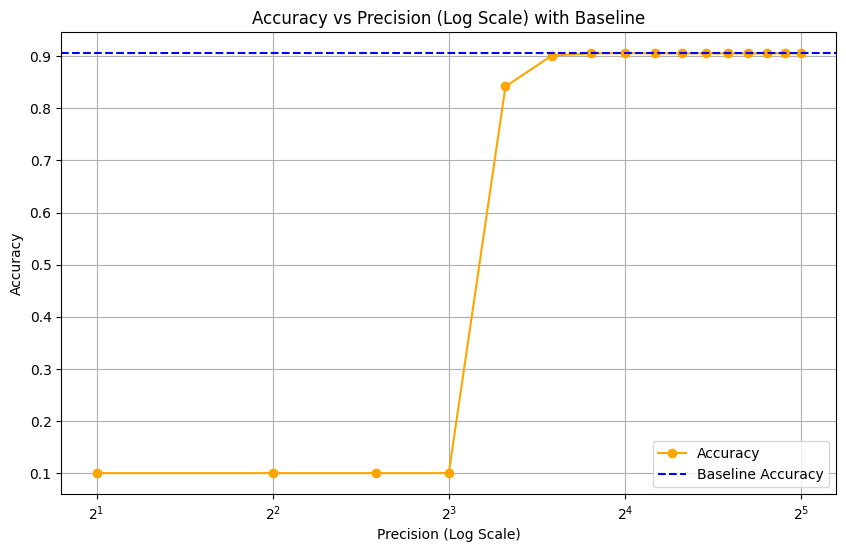

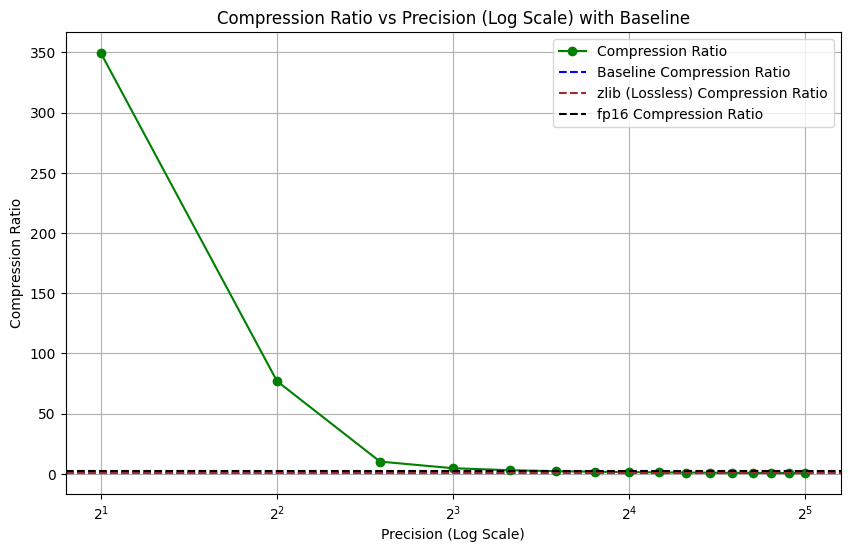

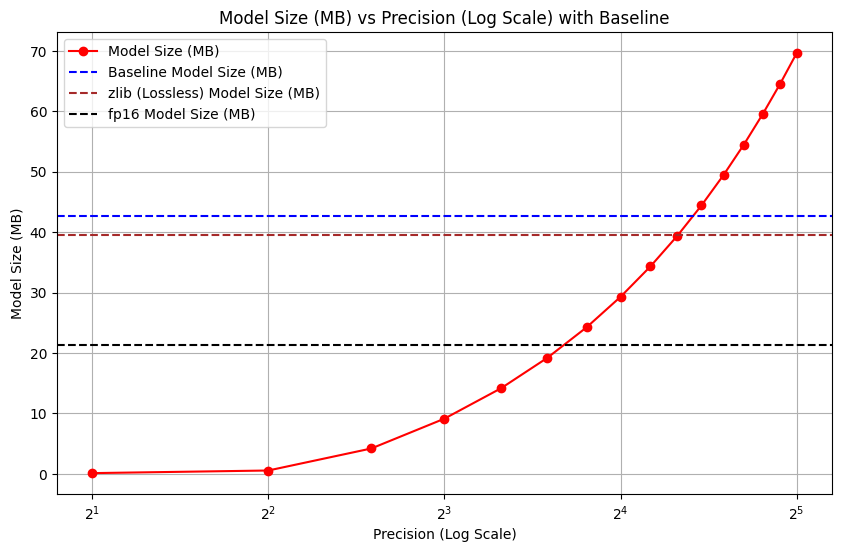

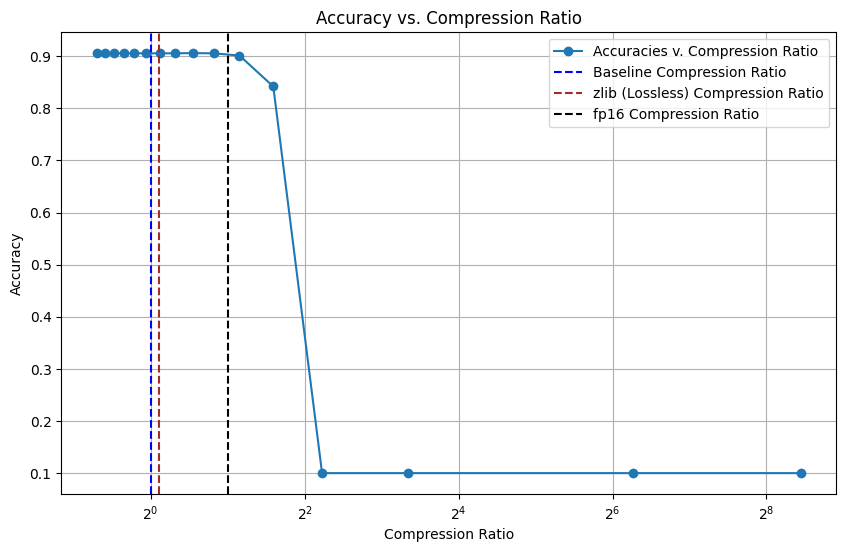

In [13]:
data = [
    (accuracies, org_data['accuracy'], fp16_data['accuracy'], 'orange', 'Accuracy'),
    (compression_ratios, org_data['compression_ratio'], fp16_data['compression_ratio'], 'green', 'Compression Ratio', zlib_data['compression_ratio']),
    (model_sizes, org_data['model_size'], fp16_data['model_size'], 'red', 'Model Size (MB)', zlib_data['model_size']),
]

for d in data:
    color = d[3]
    label = d[4]
    
    plt.figure(figsize=(10, 6))

    plt.plot(precision_values, d[0], color=color, marker='o', label=label)
    plt.axhline(y=d[1], color='blue', linestyle='--', label=f'Baseline {label}')
    
    if len(d) > 5:
        plt.axhline(y=d[5], color='brown', linestyle='--', label=f'zlib (Lossless) {label}')
        
    if d[4] != "Accuracy":
        plt.axhline(y=d[2], color='black', linestyle='--', label=f'fp16 {label}')

    plt.title(f'{label} vs Precision (Log Scale) with Baseline')
    plt.xscale('log', base=2)
    plt.xlabel('Precision (Log Scale)')
    plt.ylabel(label)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{kaggle_save}{label}.png")

    plt.show()
    
plt.figure(figsize=(10, 6))
plt.plot(compression_ratios, accuracies, marker='o', label="Accuracies v. Compression Ratio")
plt.title(f'Accuracy vs. Compression Ratio')
plt.xlabel('Compression Ratio')
plt.ylabel('Accuracy')

#Compressed Baseline
plt.axvline(x=1, color='blue', linestyle='--', label=f'Baseline {data[1][4]}')
plt.axvline(x=data[1][5], color='brown', linestyle='--', label=f'zlib (Lossless) {data[1][4]}')
plt.axvline(x=data[1][2], color='black', linestyle='--', label=f'fp16 {data[1][4]}')

plt.xscale('log', base=2)
plt.legend()
plt.grid(True)
plt.savefig(f"{kaggle_save}acc_v_comp.png")
plt.show()